# Coresets via Bilevel Optimization
This notebook containts a simple demo on how generate coresets with the library. This is showcased on a toy regression problem and on MNIST.


Run the following when using Colab (GPU runtime preferred):

In [1]:
! git clone https://github.com/zalanborsos/bilevel_coresets
% cd bilevel_coresets
! pip install -r requirements.txt

If you are running with GPU runtime, install the GPU version of JAX (make sure the colab and the jax cuda versions concide):

In [ ]:
! pip install --upgrade jax jaxlib==0.1.56+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

If you need to restart the colab kernel after installing the requirements, run the following command after restart

In [ ]:
% cd bilevel_coresets

## Regression
Let us solve a rigde regression problem in 1D on a random subset of the data, where the underlying true model is a sine function. We will first work in the feature space corresponding to 7th order polynomials.


MSE 3596.766555744238


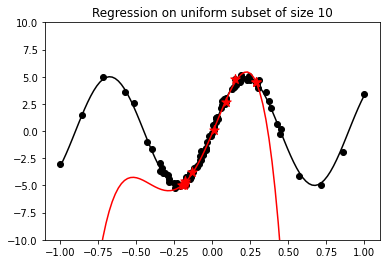

interactive(children=(IntSlider(value=10, description='subset_size', max=30, min=5), Output()), _dom_classes=(…

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import bilevel_coreset
import loss_utils
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

np.random.seed(0)

# generate data
lim = 1
x = np.random.randn(85) * 0.2
x = x[np.logical_and(x <= lim, x >= -lim)]
x_linspace = np.linspace(-lim, lim, num=15)
x = np.concatenate((x, x_linspace))
x = x.reshape(-1, 1)

true_fn = lambda x: 5 * np.sin(x * 7)
y = true_fn(x.reshape(-1)) + 0.25 * np.random.randn(x.shape[0])

# set the regularizer
reg = 1e-6

# map X to 7-th degree poly features
poly_features = PolynomialFeatures(7)
x_features = poly_features.fit_transform(x)


def solve_regression(X, y):
    return np.linalg.pinv(X.T.dot(X) + reg * np.eye(X.shape[1])).dot(X.T).dot(y)


def plot_solution(theta_hat, x_chosen, y_chosen, title=''):
    x_linspace = np.linspace(-lim, lim, num=100)
    y_linspace = true_fn(x_linspace)
    plt.plot(x_linspace, y_linspace, c='black')
    x_lin_transf = poly_features.transform(x_linspace.reshape(-1, 1))
    plt.plot(x_linspace, x_lin_transf.dot(theta_hat), c='red')
    plt.scatter(x, y, c='black')
    plt.scatter(x_chosen, y_chosen, c='red', s=100, marker='*', zorder=10)
    plt.ylim(-10, 10)
    plt.title(title)

def solve_uniform(subset_size):
    # sample subset_size points uniformly at random and solve the regression
    chosen_inds = np.random.choice(x.shape[0], subset_size, replace=False)
    theta_hat = solve_regression(x_features[chosen_inds], y[chosen_inds])
    plot_solution(theta_hat, x[chosen_inds], y[chosen_inds], 'Regression on uniform subset of size {}'.format(subset_size))
    print('MSE', np.mean((x_features.dot(theta_hat) - y) ** 2))
    
solve_uniform(10)
interact(solve_uniform, subset_size=widgets.IntSlider(min=5, max=30, step=1, value=10));

Now we solve the subset selection with our coreset selection method. For this demo we simply use unweighted coreset points by setting the number of outer iterations to 1. Notice how we can achieve much lower MSE with coresets compared to uniform subsamples with the same size.

10 MSE 0.2870781796218779


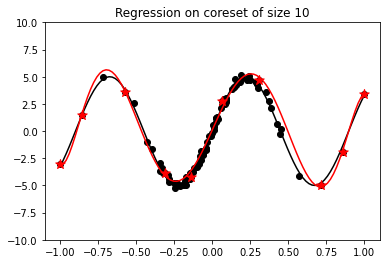

interactive(children=(IntSlider(value=10, description='subset_size', max=30, min=5), Output()), _dom_classes=(…

In [2]:
poly_kernel = lambda x1, x2: np.dot(poly_features.transform(x1), poly_features.transform(x2).T)

bc = bilevel_coreset.BilevelCoreset(outer_loss_fn=loss_utils.weighted_mse,
                                    inner_loss_fn=loss_utils.weighted_mse, out_dim=1, max_outer_it=1,
                                    inner_lr=0.25, max_inner_it=500, logging_period=100)
coreset_inds, _ = bc.build_with_representer_proxy_batch(x, y.reshape(-1, 1), 30, kernel_fn_np=poly_kernel,
                                                        cache_kernel=True, start_size=3, inner_reg=reg)

def solve_coreset(subset_size):
    chosen_inds = coreset_inds[:subset_size]
    theta_hat = solve_regression(x_features[chosen_inds], y[chosen_inds])
    plot_solution(theta_hat, x[chosen_inds], y[chosen_inds], 'Regression on coreset of size {}'.format(subset_size))
    print(subset_size, 'MSE', np.mean((x_features.dot(theta_hat) - y) ** 2))

solve_coreset(10)
interact(solve_coreset, subset_size=widgets.IntSlider(min=5, max=30, step=1, value=10));

## MNIST
We will create a subset of size 50 of the MNIST training data with uniform subsampling and with coresets generation. Then, we will train a CNN on these subset and evaluate its test accuracy.
 
###  Uniform sample

In [4]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F

subset_size = 50

np.random.seed(0)
torch.manual_seed(0)

mnist_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST(root='data', train=True, transform=mnist_transforms, download=True)
test_dataset = datasets.MNIST('data', train=False, transform=mnist_transforms)

# choose random inds
uniform_inds = np.random.choice(train_dataset.data.shape[0], subset_size, replace=False)
uniform_subset = Subset(train_dataset, uniform_inds)


Let's look at the training points we selected via uniform sampling.

Number of points selected per class [9 2 6 5 2 3 7 6 5 5]


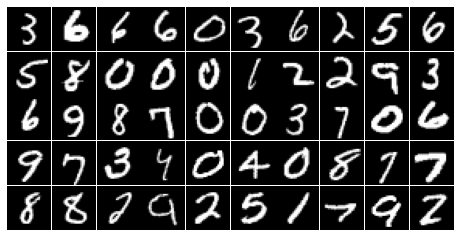

In [5]:
print('Number of points selected per class', np.bincount(train_dataset.targets[uniform_inds].numpy()))

def plot_points(inds):
    X = train_dataset.data[inds].numpy()
    fig = plt.figure(figsize=(8., 13.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, len(inds) // 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

    for ax, im in zip(grid, X):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap='gray')
        ax.axis('off')
    plt.axis('off')
    
plot_points(uniform_inds)

Now we train a CNN on these 50 points, and measure its test accuracy on the full dataset, which should be around 72-74%.

In [6]:
import models

def train_model(model, loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=5 * 1e-4)
    for epoch in range(nr_epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

def test_model(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 1. * correct / len(loader.dataset)
    return test_acc

nr_classes = 10
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nr_epochs = 1000

net = models.ConvNet(output_dim=nr_classes).to(device)
train_loader = torch.utils.data.DataLoader(uniform_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_model(net, train_loader)
print('Uniform sample - Train accuracy', test_model(net, train_loader))
print('Uniform sample - Test accuracy', test_model(net, test_loader))

Uniform sample - Train accuracy 1.0
Uniform sample - Test accuracy 0.7173


### Coreset
We need to specify a proxy model for coreset generation for which we use the Neural Tangent Kernel corresponding to our CNN architecture. Note: calculating the NTK is much faster on GPU, so make sure to use a GPU backend.

In [7]:
from jax.api import jit
from neural_tangents import stax
import neural_tangents as nt

_, _, kernel_fn = stax.serial(
        stax.Conv(32, (5, 5), (1, 1), padding='SAME', W_std=1., b_std=0.05),
        stax.Relu(),
        stax.Conv(64, (5, 5), (1, 1), padding='SAME', W_std=1., b_std=0.05),
        stax.Relu(),
        stax.Flatten(),
        stax.Dense(128, 1., 0.05),
        stax.Relu(),
        stax.Dense(10, 1., 0.05))
kernel_fn = jit(kernel_fn, static_argnums=(2,))

def generate_cnn_ntk(X, Y):
    n = X.shape[0]
    m = Y.shape[0]
    K = np.zeros((n, m))
    for i in range(m):
        K[:, i:i + 1] = np.array(kernel_fn(X, Y[i:i + 1], 'ntk'))
    return K

proxy_kernel_fn = lambda x, y: generate_cnn_ntk(x.view(-1, 28, 28, 1).numpy(), y.view(-1, 28, 28, 1).numpy())

We are now ready to build the coreset. While we could optimize the coreset weights, for this demo we simply use unweighted coreset points.

In [11]:
# work only on the first 2500 samples for speedup
# higher limit will result in better results
# when using higher limits, set cache_kernel=False and decrease candidate_batch_size

limit = 2500

loader = torch.utils.data.DataLoader(train_dataset, batch_size=limit, shuffle=False)
X, y = next(iter(loader))

bc = bilevel_coreset.BilevelCoreset(outer_loss_fn=loss_utils.cross_entropy,
                                    inner_loss_fn=loss_utils.cross_entropy, out_dim=10,
                                    candidate_batch_size=1000,
                                    max_outer_it=1)
coreset_inds, _ = bc.build_with_representer_proxy_batch(X, y, subset_size, proxy_kernel_fn, cache_kernel=True,
                                                        start_size=1, inner_reg=1e-7)

Coreset size 10, outer_loss 1.43, inner loss 0.00036
Coreset size 20, outer_loss 1.1, inner loss 0.000611
Coreset size 30, outer_loss 0.834, inner loss 0.000863
Coreset size 40, outer_loss 0.703, inner loss 0.0011
Coreset size 50, outer_loss 0.601, inner loss 0.00132


Number of points selected per class [4 3 6 6 6 6 4 4 6 5]


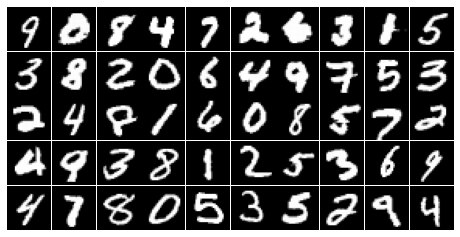

In [12]:
print('Number of points selected per class', np.bincount(train_dataset.targets[coreset_inds].numpy()))
plot_points(coreset_inds)

We can notice that in each step, the method selects the sample that has the potential to increase the accuracy by the largest amount: the first 10 samples (first row) are picked from different classes, after which the method starts to diversify within the classes. Even though the dataset is balanced over classes, our method chooses more samples from harder classes.

In [10]:
net = models.ConvNet(output_dim=nr_classes).to(device)
coreset_subset = Subset(train_dataset, coreset_inds)
train_loader = torch.utils.data.DataLoader(coreset_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_model(net, train_loader)
print('Coreset - Train accuracy', test_model(net, train_loader))
print('Coreset - Test accuracy', test_model(net, test_loader))

Coreset - Train accuracy 1.0
Coreset - Test accuracy 0.8833


The test accuracy of the CNN on the coreset is ~13% better than on the uniform sample.